In [2]:
import pickle
DATASET_DIR =  "drive/MyDrive/text_data/"

In [3]:
def read_pickle(fn):
	with open(fn, "rb") as f:
		return pickle.load(f)
	
def get_all_unique_words(descriptions):
  words = []
  for text in descriptions:
    words += text.split() 
  return list(set([word.lower() for word in words]))

In [15]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(DATASET_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(DATASET_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_info = read_pickle(DATASET_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(DATASET_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(DATASET_DIR + "item_to_room.p")
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(DATASET_DIR + "room_to_items.p")

# Some simple preprossing
item_to_description = {key : value["desc"] for key, value in item_to_description.items()}
unique_descriptions = list(set(item_to_description.values()))

In [10]:
!pip install glove-python-binary

     |████████████████████████████████| 948 kB 5.2 MB/s 


In [60]:
from glove import Glove
from glove import Corpus
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [83]:
unique_descriptions = list(set(item_to_description.values()))
corpus_word = []
for sentence in unique_descriptions:
  split_sentence = sentence.split(" ")
  normal_sentence = []
  for word in split_sentence:
    word = word.lower()
    normal_word = ''
    for letter in word:
      if letter in ['.',',','?','!','(', ')']:
        continue
      normal_word += letter
    if word not in stopwords.words("english") and word != '':
      normal_sentence.append(normal_word)
  corpus_word.append(normal_sentence)


In [92]:
corpus_word[268]

['cowhide', 'naturally', 'durable', 'last', 'many', 'years']

In [93]:
corpus_model = Corpus()
corpus_model.fit(corpus_word, window=10)

In [94]:
glove = Glove(no_components=100, learning_rate=0.05)
glove.fit(corpus_model.matrix, epochs=10, verbose=True)
glove.add_dictionary(corpus_model.dictionary)

Performing 10 training epochs with 2 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9


In [95]:
glove.most_similar('clock', number = 10)

[('memorabil', 0.33158148005741883),
 ('365+', 0.310361195520425),
 ('fastening', 0.29950095213840755),
 ('shutting', 0.29613244281115003),
 ('reduce', 0.2955676978841679),
 ('arent', 0.2872893049395707),
 ('outfit', 0.2779289472204237),
 ('cut', 0.2723800491736876),
 ('combinations', 0.2689526901309764)]

In [64]:
glove.word_vectors[glove.dictionary['table']]

array([ 5.43969996e-03, -5.55678049e-03,  4.31948525e-03,  2.74975664e-03,
        3.88322417e-03,  2.76989149e-04,  9.79988830e-04, -6.03915713e-04,
       -5.92372606e-04, -5.42246074e-03, -2.32826632e-03,  1.49654058e-03,
        1.93591181e-03, -3.90692276e-03,  3.25658044e-03, -2.55444459e-03,
       -3.42281277e-03, -6.48087288e-04,  3.71013299e-03,  2.71045792e-03,
       -2.68484110e-03,  4.09673828e-03,  1.60373495e-03,  1.55351128e-03,
       -2.98750313e-03, -7.39547401e-05, -2.95867077e-03,  5.75183513e-03,
        5.26800655e-05,  4.07632063e-03, -3.00093305e-03,  4.81187642e-03,
       -1.69298774e-03, -2.57861144e-03,  3.45969525e-03, -5.63965055e-03,
       -6.82015095e-03, -2.75517906e-03,  2.59164570e-03, -2.72113634e-03,
        2.06246526e-03, -2.47824282e-03, -8.14561121e-04,  1.44636057e-03,
        7.23084458e-03,  6.50038539e-03, -1.70104847e-03, -2.30154721e-03,
       -1.02702233e-03, -3.23329675e-03, -3.37854273e-05, -1.63629047e-03,
       -4.50449078e-03, -

In [98]:
glove_word_to_emb_dict = {}
for i, key in enumerate(glove.dictionary.keys()):
  if i < 200:
    glove_word_to_emb_dict[key] = glove.word_vectors[glove.dictionary[key]]

In [67]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

def tsne_plot(word_to_emb_dict):
    # https://www.kaggle.com/jeffd23/visualizing-word-vectors-with-t-sne
    # In word_to_emb_dict, we map a word to corresponding numpy embedding vector of shape (n, )
    labels = []
    tokens = []

    for word, emb in word_to_emb_dict.items():
      tokens.append(emb)
      labels.append(word)
    
    
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

    x = []
    y = []
    for value in new_values:
        x.append(value[0])
        y.append(value[1])
        
    plt.figure(figsize=(20, 20)) 
    for i in range(len(x)):
        plt.scatter(x[i],y[i])
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

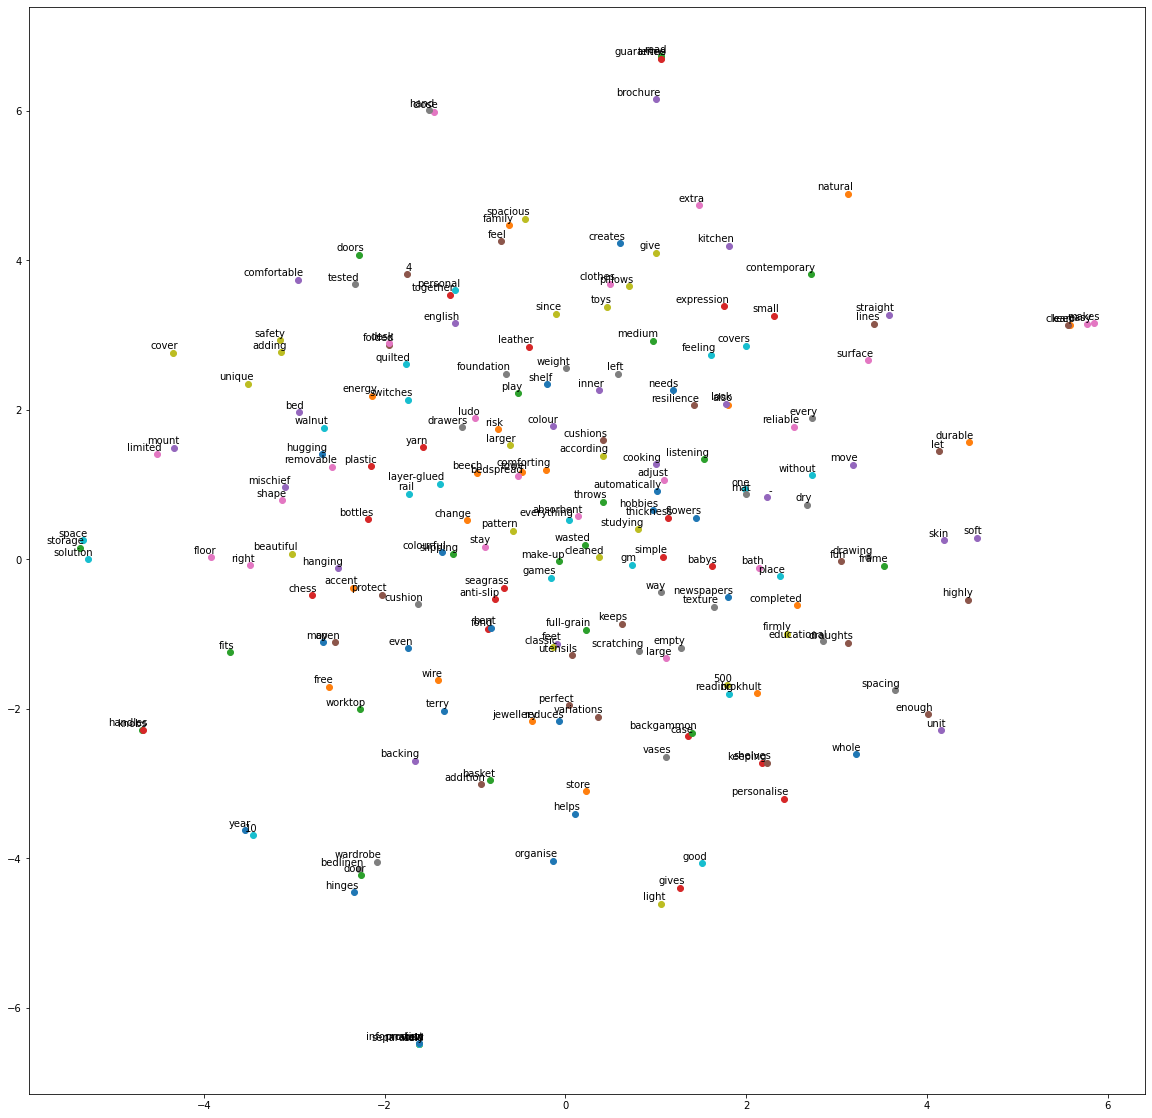

In [99]:
tsne_plot(glove_word_to_emb_dict)

In [73]:
len(glove_word_to_emb_dict.keys())

300